In [202]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import optimize

In [203]:
data = pd.read_csv("traffic_violations.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70340 entries, 0 to 70339
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Description              70340 non-null  object 
 1   Belts                    70340 non-null  object 
 2   Personal.Injury          70340 non-null  object 
 3   Property.Damage          70340 non-null  object 
 4   Commercial.License       70340 non-null  object 
 5   Commercial.Vehicle       70340 non-null  object 
 6   State                    70337 non-null  object 
 7   VehicleType              70340 non-null  object 
 8   Year                     69906 non-null  float64
 9   Make                     69892 non-null  object 
 10  Model                    69885 non-null  object 
 11  Color                    69452 non-null  object 
 12  Charge                   70340 non-null  object 
 13  Contributed.To.Accident  70340 non-null  object 
 14  Race                  

In [204]:
#Preprocesamiento de datos
to_convert = ['Belts', 'Personal.Injury', 'Property.Damage', 'Commercial.License', 'Commercial.Vehicle', 'State', 'VehicleType', 'Contributed.To.Accident', 'Race', 'Gender', 'Driver.State', 'DL.State', 'Arrest.Type', 'Violation.Type']
id2label = {}
label2id = {}
for col in to_convert:
    id2label[col] = {i: cls for i, cls in enumerate(data[col].unique())}
    label2id[col] = {cls: i for i, cls in id2label[col].items()}
    data[col] = data[col].replace(label2id[col])
    print(label2id[col])

num_labels = 3

{'No': 0, 'Yes': 1}
{'No': 0, 'Yes': 1}
{'No': 0, 'Yes': 1}
{'No': 0, 'Yes': 1}
{'No': 0, 'Yes': 1}


C:\Users\Hiro\AppData\Local\Temp\ipykernel_5076\3350727445.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace(label2id[col])


{'NC': 0, 'MD': 1, 'IL': 2, 'PA': 3, 'VA': 4, 'DC': 5, 'VT': 6, 'LA': 7, 'XX': 8, 'WV': 9, 'TX': 10, 'MI': 11, 'TN': 12, 'CA': 13, 'DE': 14, 'AL': 15, 'WA': 16, 'NJ': 17, 'GA': 18, 'US': 19, 'MT': 20, 'FL': 21, 'KY': 22, 'MN': 23, 'OK': 24, 'AK': 25, 'IN': 26, 'OH': 27, 'WI': 28, 'NY': 29, 'MA': 30, 'AZ': 31, 'IA': 32, 'CT': 33, 'SC': 34, 'CO': 35, 'NV': 36, 'MO': 37, 'KS': 38, 'NE': 39, 'NH': 40, 'RI': 41, 'ME': 42, 'AR': 43, 'NS': 44, nan: 45, 'NM': 46, 'MS': 47, 'ID': 48, 'HI': 49, 'PR': 50, 'UT': 51, 'OR': 52, 'ND': 53, 'MB': 54, 'SD': 55, 'ON': 56, 'VI': 57}
{'02 - Automobile': 0, '05 - Light Duty Truck': 1, '28 - Other': 2, '01 - Motorcycle': 3, '08 - Recreational Vehicle': 4, '03 - Station Wagon': 5, '06 - Heavy Duty Truck': 6, '29 - Unknown': 7, '19 - Moped': 8, '07 - Truck/Road Tractor': 9, '25 - Utility Trailer': 10, '10 - Transit Bus': 11, '20 - Commercial Rig': 12, '12 - School Bus': 13, '04 - Limousine': 14, '27 - Farm Equipment': 15, '24 - Camper': 16, '14 - Ambulance(Non

In [205]:
#Selección de las columnas para x y y
x = data.iloc[:, [1, 2, 3, 4, 5, 6, 7, 13, 14, 15, 17, 18, 19]]
y = data.iloc[:, 20]

num_labels = 3

x = x.to_numpy()
y = y.to_numpy()

print(x)
print(y)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  1  1  0]
 [ 0  0  0 ...  1  1  1]
 ...
 [ 0  0  0 ... 46 28  0]
 [ 0  0  0 ...  1  1  3]
 [ 0  0  0 ...  1  1  1]]
[0 0 0 ... 2 2 2]


In [206]:
#Normalización de los datos
def featureNormalize(x):
    mu = np.mean(x, axis=0)
    sigma = np.std(x, axis=0)
    x_norm = (x - mu) / sigma
    return x_norm, mu, sigma
    

x, mu, sigma = featureNormalize(x)
print(x)

[[-0.18738193 -0.1076636  -0.14020247 ... -0.51180233 -0.44677004
  -0.36644787]
 [-0.18738193 -0.1076636  -0.14020247 ... -0.19936861 -0.22701685
  -0.36644787]
 [-0.18738193 -0.1076636  -0.14020247 ... -0.19936861 -0.22701685
   0.25712343]
 ...
 [-0.18738193 -0.1076636  -0.14020247 ... 13.860149    5.70631918
  -0.36644787]
 [-0.18738193 -0.1076636  -0.14020247 ... -0.19936861 -0.22701685
   1.50426601]
 [-0.18738193 -0.1076636  -0.14020247 ... -0.19936861 -0.22701685
   0.25712343]]


In [207]:
#Generar set de entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, x_test.shape

((56272, 13), (14068, 13))

In [208]:
#Función de activación sigmoid
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [209]:
#Función de costo y descenso por el gradiente
def lrCostFunction(theta, x, y, lambda_):
    m = y.size
    h = sigmoid(x.dot(theta.T))
    theta = theta.copy()
    theta[0] = 0
    j = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(theta))
    grad = (1 / m) * (h - y).dot(x) 
    grad = grad + (lambda_ / m) * theta
    return j, grad

In [210]:
#Función para el cálculo de los valores de theta
def oneVsAll(x, y, num_labels, lambda_):
    m, n = x.shape
    all_theta = np.zeros((num_labels, n + 1))
    x = np.concatenate([np.ones((m, 1)), x], axis=1)
    all_j_history = []
    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)
        j_history = []
        def costFunction(theta, x, y, lambda_):
            j, grad = lrCostFunction(theta, x, y, lambda_)
            j_history.append(j)
            return j, grad
        options = {'maxiter': 1000}
        res = optimize.minimize(costFunction,
                                initial_theta,
                                (x, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
        all_theta[c] = res.x
        all_j_history.append(j_history)
    return all_theta, all_j_history

In [211]:
lambda_ = 0.1
all_theta, all_j_history = oneVsAll(x_train, y_train, num_labels, lambda_)
print(all_theta)

[[-0.12153675  0.03850247  0.2633602   0.31615497  0.01215109 -0.05447724
   0.0386147   0.00254991  0.28578489  0.08139152  0.15209387 -0.1049816
   0.05081384  0.15910059]
 [-4.06343298  0.00972486 -0.33499591 -0.42900887  0.01221565  0.01778066
  -4.44726927  0.09920669 -0.27194091  0.09613036  0.01095432  0.02275147
  -0.09791707 -0.48633238]
 [-0.08125815 -0.04023355 -0.24465872 -0.29069566 -0.01414238  0.04304805
   0.00914749 -0.01664798 -0.26589473 -0.10043394 -0.15091904  0.10930154
  -0.04329409 -0.10821152]]


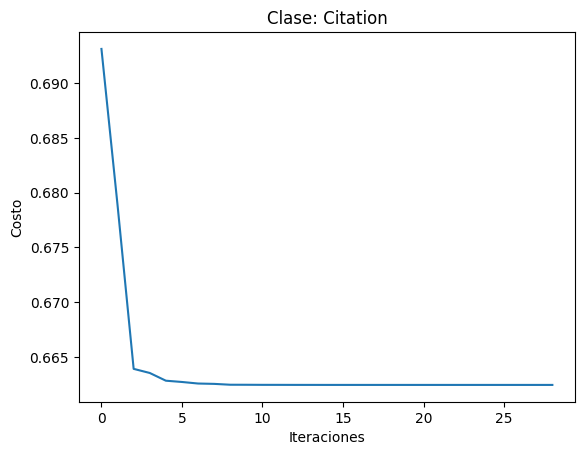

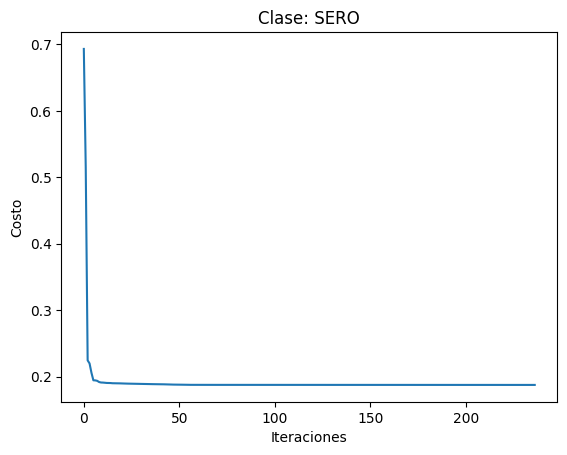

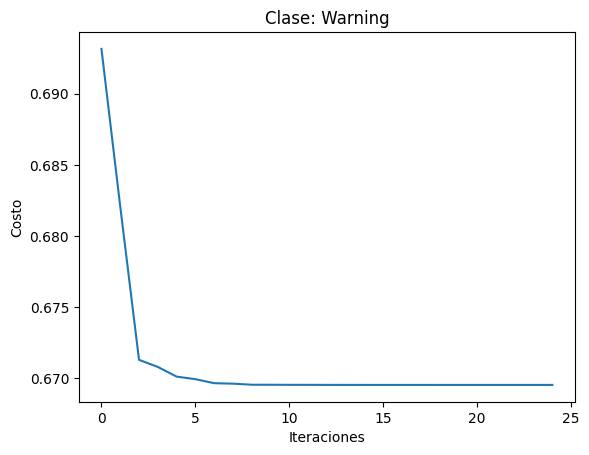

In [212]:
#Gráficas de coste de los valores de theta para las distintas clases
for i, j_history in enumerate(all_j_history):
    plt.plot(j_history)
    plt.title(f'Clase: {id2label['Violation.Type'][i]}')
    plt.xlabel('Iteraciones')
    plt.ylabel('Costo')
    plt.show()

In [213]:
#Función para ejecutar el modelo generado
def predictOneVsAll(all_theta, x):
    m = x.shape[0];
    x = np.concatenate([np.ones((m, 1)), x], axis = 1)
    p = np.argmax(sigmoid(x.dot(all_theta.T)), axis = 1)
    return p

In [214]:
#Ejemplo de las predicciones realizadas por el modelo
p = predictOneVsAll(all_theta, x_test)
print('Precision del conjunto de entrenamiento: {:.2f}%'.format(np.mean(p == y_test) * 100))
x_test_1 = x_test[0:100, :].copy()
p = predictOneVsAll(all_theta, x_test_1)
print("Predicciones:")
print(p)
print("Valores reales:")
print(y_test[0:100])

Precision del conjunto de entrenamiento: 54.21%
Predicciones:
[2 2 0 0 2 0 2 2 2 0 0 2 2 2 2 0 2 2 0 2 2 2 0 0 0 2 2 0 2 0 2 0 0 0 2 2 2
 2 0 2 2 0 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 0 2 0 0 0 2 2 0 0 2 0 2
 0 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 0 2 2 0 2 0 2 2 0 2]
Valores reales:
[0 0 2 0 1 0 0 0 2 0 2 2 0 0 0 0 2 2 2 2 2 2 2 0 0 2 2 1 2 0 0 2 0 2 2 2 2
 0 2 0 2 2 2 2 0 0 2 1 2 0 0 0 2 0 2 0 0 0 2 2 0 2 0 2 2 2 0 2 2 0 1 0 2 2
 2 0 2 1 2 2 2 0 0 2 2 2 2 2 0 2 2 0 0 0 2 0 0 0 0 0]
